<a href="https://colab.research.google.com/github/Aravind2244/DEEP-LEARNING/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Dataset path after manual upload to Google Colab
DATASET_DIR = "/content/Mendeley COVID CXR Images.zip"

In [ ]:
# Set image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

In [ ]:
import shutil
from pathlib import Path
import zipfile

# Assuming your dataset zip file is in the current directory
DATASET_DIR = "/content/Mendeley COVID CXR Images.zip"
DATASET_EXTRACTED_DIR = "/content/Mendeley COVID CXR Images" # Specify the extraction directory

# Unzip the dataset
with zipfile.ZipFile(DATASET_DIR, 'r') as zip_ref:
    zip_ref.extractall(DATASET_EXTRACTED_DIR)

# Now use the extracted directory path
img_dir = Path(DATASET_EXTRACTED_DIR)
class_dir = img_dir / "COVID"
class_dir.mkdir(exist_ok=True)
for img_file in img_dir.glob("*.jpg"):
    shutil.move(str(img_file), class_dir / img_file.name)

In [ ]:
# Load data from reorganized structure
train_data = datagen.flow_from_directory(
    str(img_dir),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)
val_data = datagen.flow_from_directory(
    str(img_dir),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 295 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [ ]:
# Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add custom layers
global_avg_pooling = GlobalAveragePooling2D()(base_model.output)
dropout = Dropout(0.3)(global_avg_pooling)
out_layer = Dense(1, activation='sigmoid')(dropout)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile model
model = Model(inputs=base_model.input, outputs=out_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_data, validation_data=val_data, epochs=5)

# Save trained model
model.save("covid19_light_mobilenet_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 813ms/step - accuracy: 0.8420 - loss: 0.3612 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 8.7600e-04
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 6.6918e-04
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - accuracy: 1.0000 - loss: 9.0346e-04 - val_accuracy: 1.0000 - val_loss: 5.9170e-04
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 273ms/step - accuracy: 1.0000 - loss: 7.5262e-04 - val_accuracy: 1.0000 - val_loss: 5.6183e-04


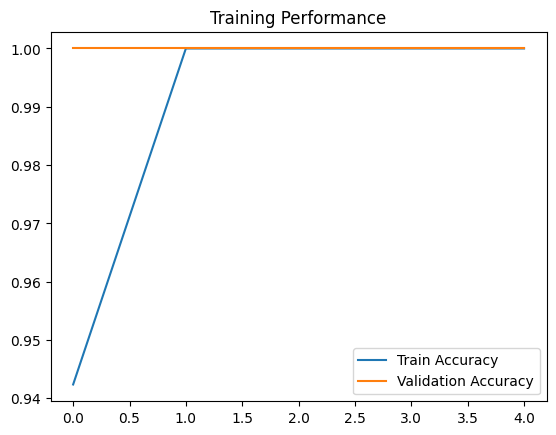

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training Performance')
plt.show()

In [ ]:
# Grad-CAM for explainability
def grad_cam(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img_input = np.expand_dims(img, axis=0) / 255.0

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer('Conv_1').output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_input)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights.numpy())

    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, IMG_SIZE)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM Visualization')
    plt.axis('off')
    plt.show()

In [ ]:
!find "/content/Mendeley COVID CXR Images" -type f

/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/163.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/186.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/211.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/334.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/224.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/46.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/105.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/282.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/283.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/72.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/234.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/135.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/255.jpg
/content/Mendeley COVID CXR Images/Mendeley COVID CXR Images/272.jpg
/content/Mendeley COVID CXR Images/M

In [ ]:
!unzip -q "/content/Mendeley COVID CXR Images.zip" -d "/content"

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step


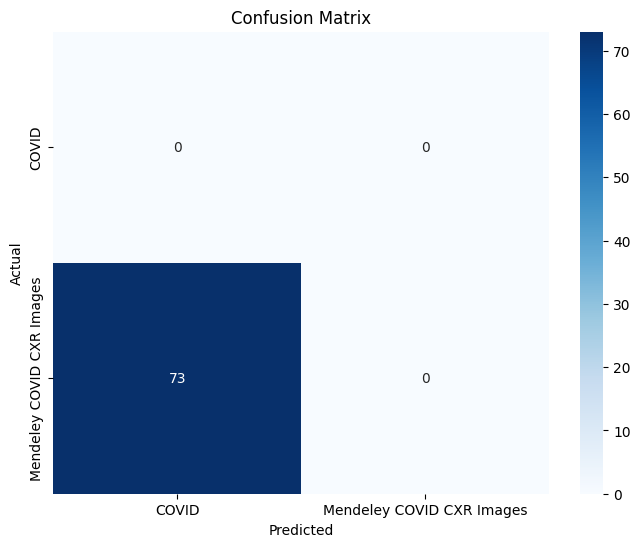

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have predictions and true labels
# Replace these with your actual predictions and true labels
# y_pred = model.predict(val_data) # Example using validation data
# y_true = val_data.classes


# Assuming 'val_data' is your validation data generator
# This is just to show the structure, it needs to be adjusted with your code
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_data.class_indices.keys(),
            yticklabels=val_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


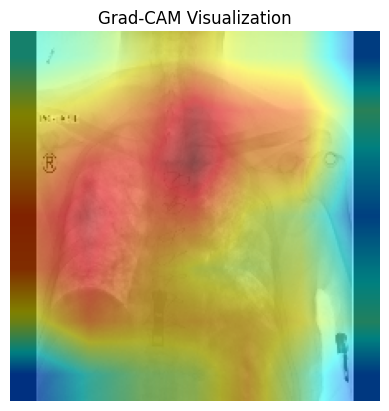

In [ ]:
from glob import glob

example_images = glob("/content/Mendeley COVID CXR Images/**/*.*", recursive=True)
example_images = [img for img in example_images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

if example_images:
    grad_cam(example_images[0], model)
else:
    print("No image files found!")


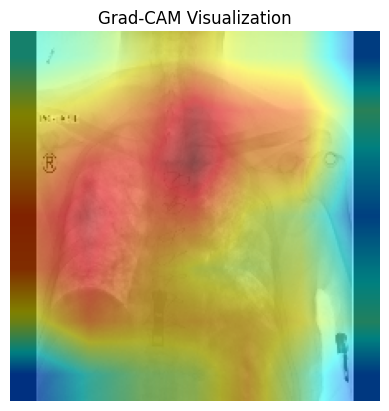

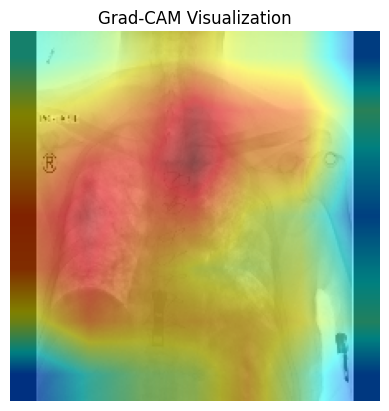

In [ ]:
# Example Grad-CAM visualization
# Example Grad-CAM visualization (recursive search for all image types)
from glob import glob

example_images = glob("/content/Mendeley COVID CXR Images**/*.*", recursive=True)
example_images = [img for img in example_images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

if example_images:
    grad_cam(example_images[0], model)
else:
    print("No image files found!")
if len(example_images) > 0:
    example_img = example_images[0]
    grad_cam(str(example_img), model)
else:
    print("No .jpg images found in the 'COVID' folder. Please ensure images are present after unzipping.")
